# CASE STUDY: Deaths in Mexico (2008)
## *Tidy Data* from Hadley Wickham

This notebook presents the use of 3 different linear models on a dataset of Mexico mortality from 2008 with the intention to prove which of these methods is better in terms of outlier recongnition and minimal residual.




---



## Translation of R into Python

Code obtained from the Github repository "*tidy-data*".

**Imports and setup of packages**

In [40]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.robust.robust_linear_model import RLM
from statsmodels.tools import add_constant

**Download and preprocessing of the dataset**

Total dataset: 539,530 deaths in 2008, Mexico. 55 variables, included Location and Time.

Variables used: Year, Month, Day and Hour of Death, Count and Diseases.

Also, there's the elimination of null values for a cleaner dataset.

In [41]:
if not os.path.exists("deaths.pkl"):
    src = "https://github.com/hadley/mexico-mortality/raw/master/deaths/deaths08.csv.bz2"

    deaths = pd.read_csv(src, compression="bz2")

    deaths.loc[deaths["hod"] == 99, "hod"] = np.nan
    deaths.loc[deaths["hod"] == 24, "hod"] = 0
    deaths.loc[deaths["hod"] == 0, "hod"] = np.nan
    deaths["hod"] = deaths["hod"].astype("Int64")

    deaths = deaths.sort_values(["yod", "mod", "dod", "hod", "cod"])
    deaths = deaths[["yod", "mod", "dod", "hod", "cod"]]

    deaths.to_pickle("deaths.pkl")

deaths = pd.read_pickle("deaths.pkl")


**Subset**

Creation of an organized sub-dataset that has the following columns:

```
[yod, mod, dod, hod, cod]
```



In [42]:
ok = deaths[
    (deaths["yod"] == 2008) &
    (deaths["mod"] != 0) &
    (deaths["dod"] != 0)
]

sample = ok.iloc[np.r_[0, np.arange(0, 14 * 2000)]][
    ["yod", "mod", "dod", "hod", "cod"]
]

sample.to_latex("raw.tex", index=False)

sample

,yod,mod,dod,hod,cod
521423,2008,1,1,1,B20
521423,2008,1,1,1,B20
248925,2008,1,1,1,B22
372027,2008,1,1,1,C18
411910,2008,1,1,1,C34
...,...,...,...,...,...
437674,2008,1,17,13,E44
521780,2008,1,17,13,F10
481729,2008,1,17,13,G20
437892,2008,1,17,13,I11


**Load ICD codes**

Here's the presentation of the sub-dataset that contains all deaths by diseases, presenting this one as a new column. The total amount of diseases (rows) are 1858.

In [43]:
codes = pd.read_csv("/content/drive/MyDrive/ML/icd-main.csv")

codes["disease"] = codes["disease"].apply(
    lambda x: "\n".join(pd.Series(x).str.wrap(30))
)

codes = codes.rename(columns={codes.columns[0]: "cod"})
codes = codes.drop_duplicates("cod")


**Overall hourly deaths**

Presents a graph that shows all the daths and their respective hour.

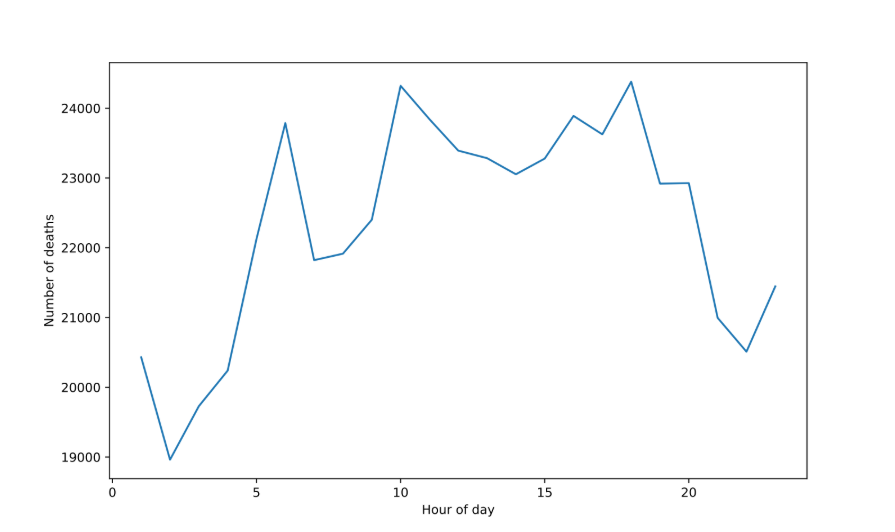

In [44]:
hod_all = (
    deaths.groupby("hod").size().reset_index(name="freq").dropna(subset=["hod"])
          )

plt.figure(figsize=(10, 6))
sns.lineplot(data=hod_all, x="hod", y="freq")
plt.xlabel("Hour of day")
plt.ylabel("Number of deaths")
plt.ticklabel_format(axis="y", style="plain")
plt.savefig("/content/drive/MyDrive/ML/overall.pdf")
plt.close()

**Deaths per hour per disease**

Being more specific, the dataset *hod2* presents the frequency on disease's deaths with their respective proportion (%)

In [45]:
hod2 = (
    deaths.groupby(["cod", "hod"]).size().reset_index(name="freq").dropna(subset=["hod"])
      )

hod2 = hod2.merge(codes, on="cod", how="left")

hod2["prop"] = hod2.groupby("cod")["freq"].transform(
    lambda x: x / x.sum()
)
hod2

,cod,hod,freq,disease,prop
0,A01,1,3,Typhoid and paratyphoid fevers,0.057692
1,A01,2,1,Typhoid and paratyphoid fevers,0.019231
2,A01,3,4,Typhoid and paratyphoid fevers,0.076923
3,A01,5,5,Typhoid and paratyphoid fevers,0.096154
4,A01,6,1,Typhoid and paratyphoid fevers,0.019231
...,...,...,...,...,...
15549,Y89,19,1,Sequelae of other external\ncauses,0.027027
15550,Y89,20,2,Sequelae of other external\ncauses,0.054054
15551,Y89,21,1,Sequelae of other external\ncauses,0.027027
15552,Y89,22,1,Sequelae of other external\ncauses,0.027027


**Overall abundance per hour**

Merge of *hod2* dataset with the total frequency of deaths on each hour (1-23 hr) and proportions. Presenting a total of 513,273

In [46]:
overall = (
    hod2.groupby("hod")["freq"].sum().reset_index(name="freq_all")
          )

overall["prop_all"] = overall["freq_all"] / overall["freq_all"].sum()

hod2 = hod2.merge(overall, on="hod", how="left")
hod2

,cod,hod,freq,disease,prop,freq_all,prop_all
0,A01,1,3,Typhoid and paratyphoid fevers,0.057692,20430,0.039803
1,A01,2,1,Typhoid and paratyphoid fevers,0.019231,18962,0.036943
2,A01,3,4,Typhoid and paratyphoid fevers,0.076923,19729,0.038438
3,A01,5,5,Typhoid and paratyphoid fevers,0.096154,22126,0.043108
4,A01,6,1,Typhoid and paratyphoid fevers,0.019231,23787,0.046344
...,...,...,...,...,...,...,...
15549,Y89,19,1,Sequelae of other external\ncauses,0.027027,22919,0.044653
15550,Y89,20,2,Sequelae of other external\ncauses,0.054054,22926,0.044666
15551,Y89,21,1,Sequelae of other external\ncauses,0.027027,20995,0.040904
15552,Y89,22,1,Sequelae of other external\ncauses,0.027027,20510,0.039959


**Select diseases to show**
Now, there will be a table that presents all diseases that have more than 100 deaths.

In [47]:
cods = (
    deaths.groupby("cod").size().reset_index(name="freq").sort_values("freq", ascending=False).merge(codes, on="cod", how="left")
      )

cods = cods[cods["freq"] > 100].tail(30)
cods["disease"] = cods["disease"].str[:30]
cods

,cod,freq,disease
320,I31,119,Other diseases of pericardium
321,Q23,118,Congenital malformations of\nao
322,C51,117,Malignant neoplasm of vulva
323,P91,116,Other disturbances of cerebral
324,X44,116,Accidental poisoning by and\nex
325,J68,115,Respiratory conditions due to\n
326,D35,114,Benign neoplasm of other and\nu
327,Y57,114,Adverse effects in therapeutic
328,J06,113,Acute upper respiratory\ninfect
329,I83,113,Varicose veins of lower\nextrem


**Extract subset for tables**

Now for certain diseases, by using also *hod2* , there will be a new table presenting our selection those diseases with the same columns from the last table *overall*.

In [48]:
hod3 = hod2[
    (hod2["cod"].isin(["I21", "N18", "E84", "B16"])) &
    (hod2["hod"].between(8, 12))
].iloc[:15][
    ["hod", "cod", "disease", "freq", "prop", "freq_all", "prop_all"]
]

hod3

,hod,cod,disease,freq,prop,freq_all,prop_all
576,8,B16,Acute hepatitis B,4,0.038095,21915,0.042697
577,9,B16,Acute hepatitis B,7,0.066667,22401,0.043643
578,10,B16,Acute hepatitis B,10,0.095238,24321,0.047384
579,11,B16,Acute hepatitis B,6,0.057143,23843,0.046453
580,12,B16,Acute hepatitis B,8,0.076190,23392,0.045574
4213,8,E84,Cystic fibrosis,3,0.029412,21915,0.042697
4214,9,E84,Cystic fibrosis,1,0.009804,22401,0.043643
4215,10,E84,Cystic fibrosis,7,0.068627,24321,0.047384
4216,11,E84,Cystic fibrosis,3,0.029412,23843,0.046453
4217,12,E84,Cystic fibrosis,5,0.049020,23392,0.045574


**Deviation analysis**

Using hod2, previously obtained.

In [49]:
devi = (
    hod2.groupby("cod").apply(lambda df: pd.Series({
                      "n": df["freq"].sum(),
                      "dist": np.mean((df["prop"] - df["prop_all"]) ** 2)
    })).reset_index()
      )

devi = devi[devi["n"] > 50]

/tmp/ipython-input-3540687494.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hod2.groupby("cod").apply(lambda df: pd.Series({


**Robust Linear Model (RLM)**

In [50]:
X = add_constant(np.log(devi["n"]))
y = np.log(devi["dist"])

rlm_model = RLM(y, X).fit()
devi["resid"] = rlm_model.resid

**Plots:**

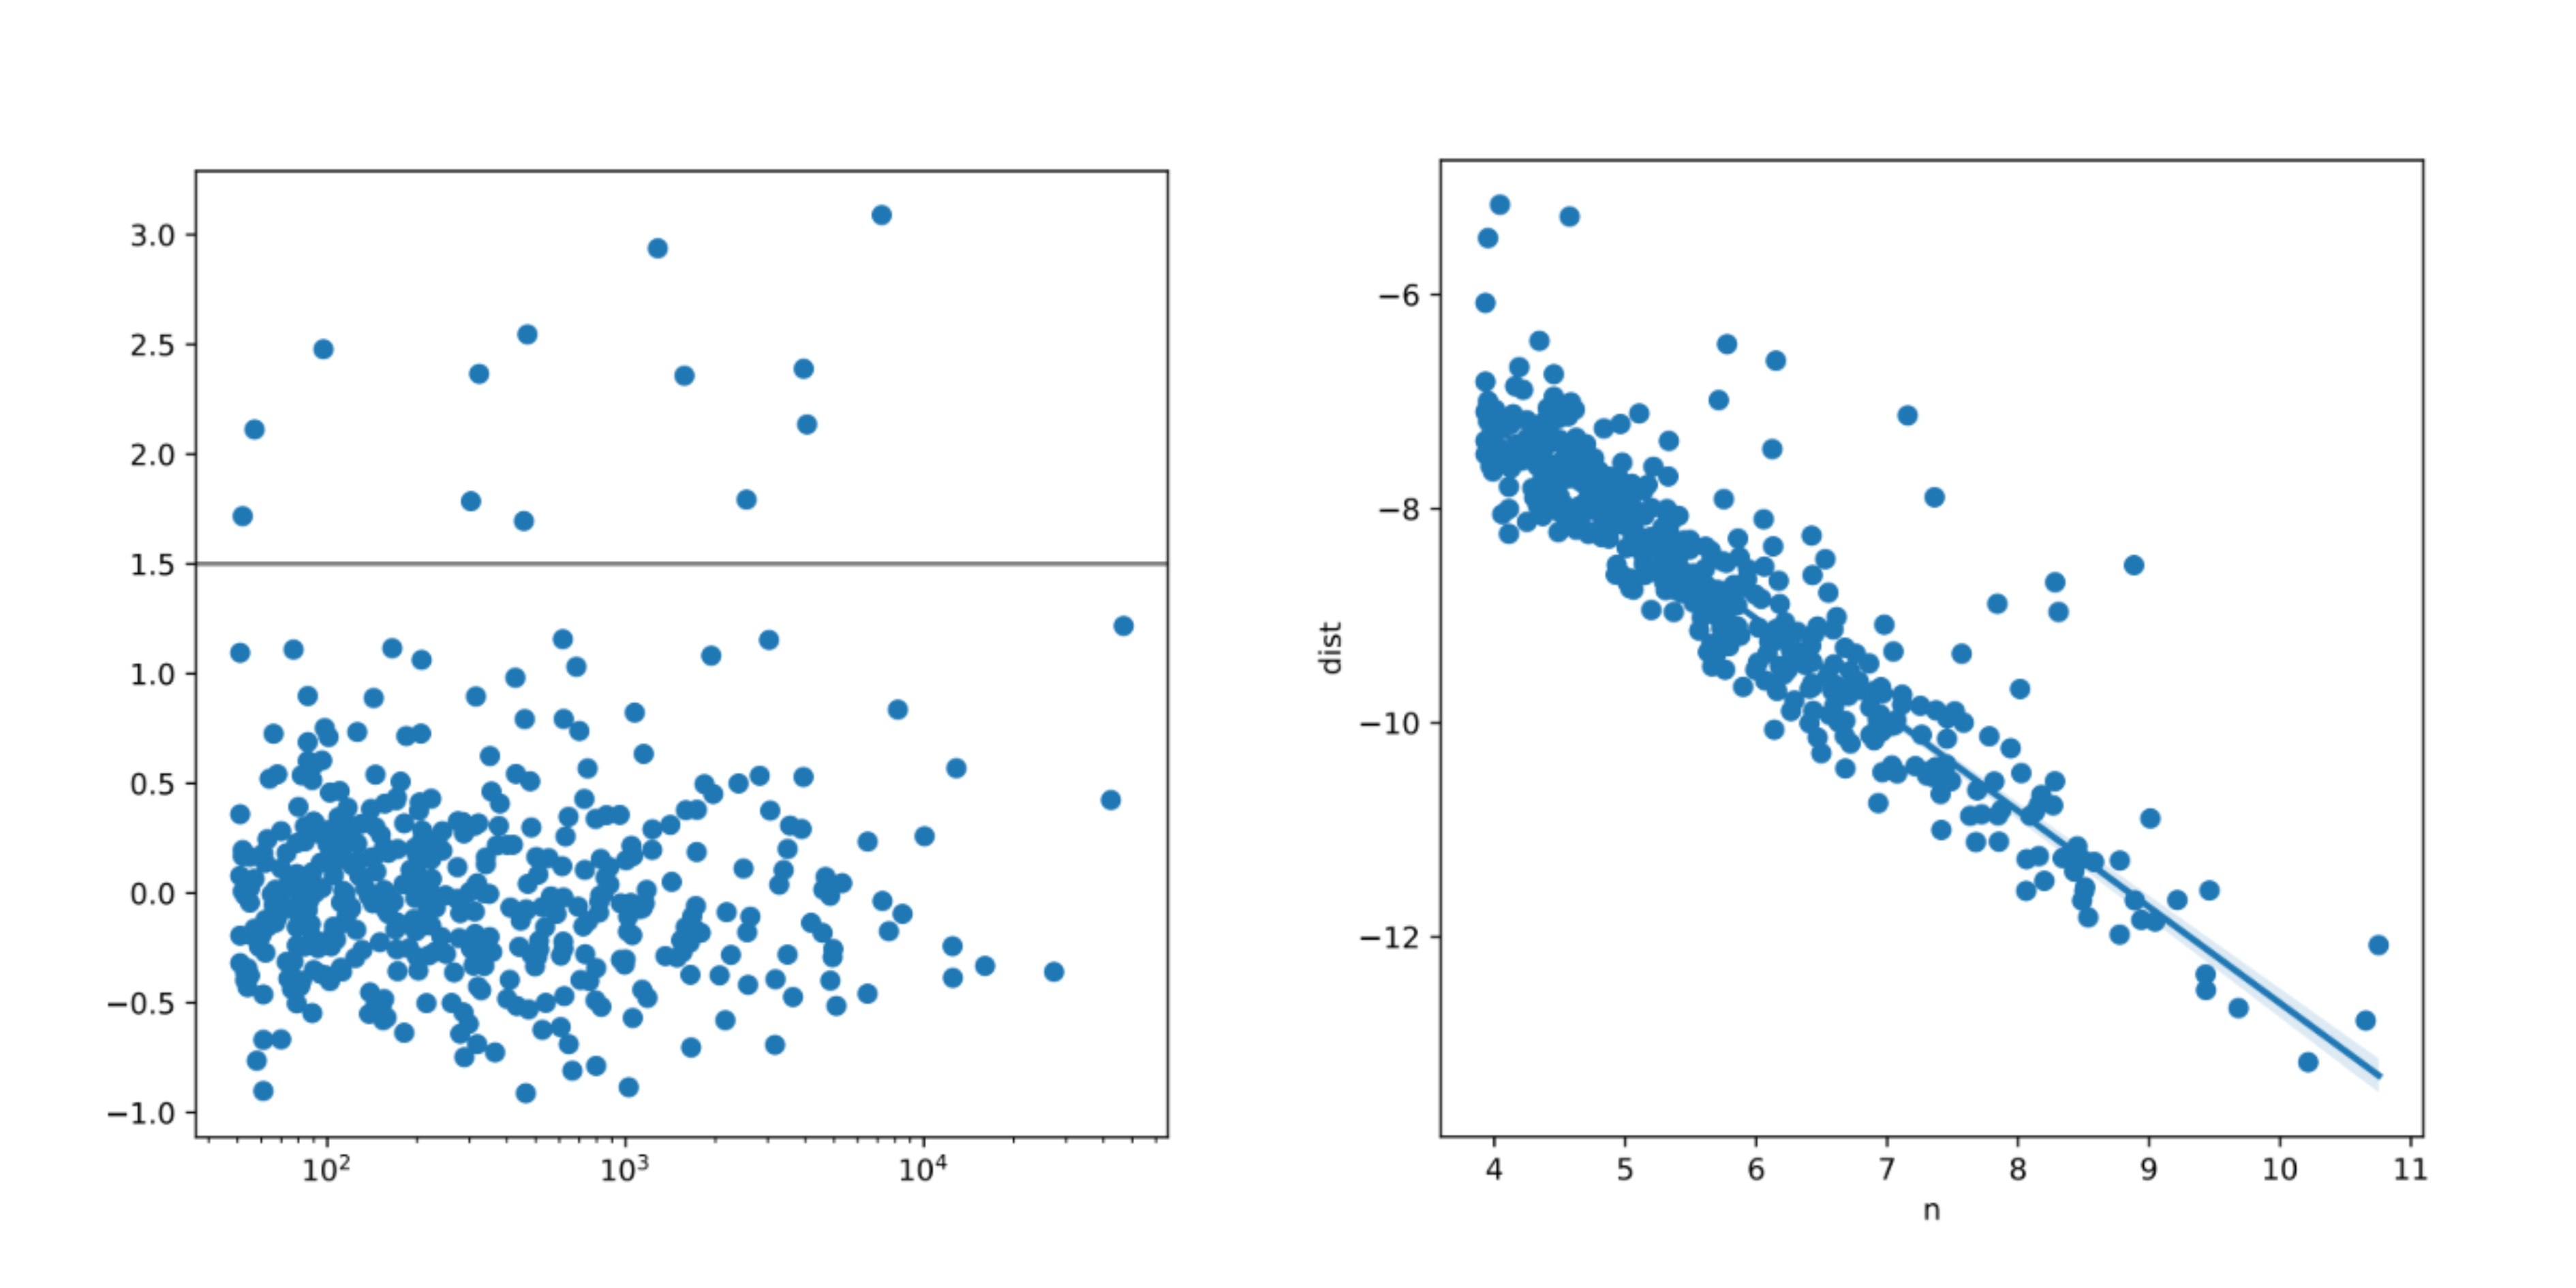

In [51]:
plt.figure(figsize=(6, 6))
sns.regplot(
    x=np.log(devi["n"]),
    y=np.log(devi["dist"]),
    scatter=False,
    robust=True
)
plt.scatter(np.log(devi["n"]), np.log(devi["dist"]))
plt.savefig("/content/drive/MyDrive/ML/n-dist-log.pdf")
plt.close()

plt.figure(figsize=(6, 6))
plt.scatter(devi["n"], devi["resid"])
plt.axhline(1.5, color="gray")
plt.xscale("log")
plt.savefig("/content/drive/MyDrive/ML/n-dist-resid.pdf")
plt.close()



---



# Methods to perform a Linear Model:

Methods selected:
- Ordinary Least Squares (OLS): standard linear regression
- Theil-Sen estimator: based on medians
- Huber Regressor: robust model

# Performance compasiron
METRIC:

- Median absolute deviation of residuals (MAD)





---



## Methods testing

First, take into account to use the devi dataset obtained from *hod2*:



```
R> devi <- ddply(hod2, "cod", summarise, n = sum(freq),
+    dist = mean((prop - prop_all)^2))
R> devi <- subset(devi, n > 50)
```

Where:



*   n: Total # of deaths for a disease (sample)
*   dist: Mean squared deviation
*   log(n): Predictor
*   log(dist): Response

Also, will be using the same log-log model.



```
X = log(n)
y = log(dist)
```




**Ordinary Least Squares**



First, state the log-log variables

In [52]:
from sklearn.linear_model import LinearRegression

X_log = np.log(devi["n"]).values.reshape(-1,1)
y_log = np.log(devi["dist"]).values

Fitting of the OLS model

In [53]:
ols = LinearRegression()
ols.fit(X_log,y_log)

LinearRegression()

Then, we obtain the coefficients beta (0 and 1):

* Beta 1 will tell us the how fats the deviation decreases as the sample size grows.

* Beta 0 will set the baseline of deviation


In [54]:
beta_0 = ols.intercept_
beta_1 = ols.coef_[0]

print("OLS slope:",beta_1)
print("OLS intercept:",beta_0)

OLS slope: -0.8690116797278272
OLS intercept: -3.7432492089203286


With these results, the conclusion is:

* If beta 1 is approximately -1, the deviation shrinks like 1/n.

Predictions and residuals of the data (OLS)

In [55]:
y_log_pred_ols = ols.predict(X_log)
devi["resid_ols"] = y_log - y_log_pred_ols
devi["dist_pred_ols"] = np.exp(y_log_pred_ols)

Based on our results, let's plot the results from the model (complete line and devi points)

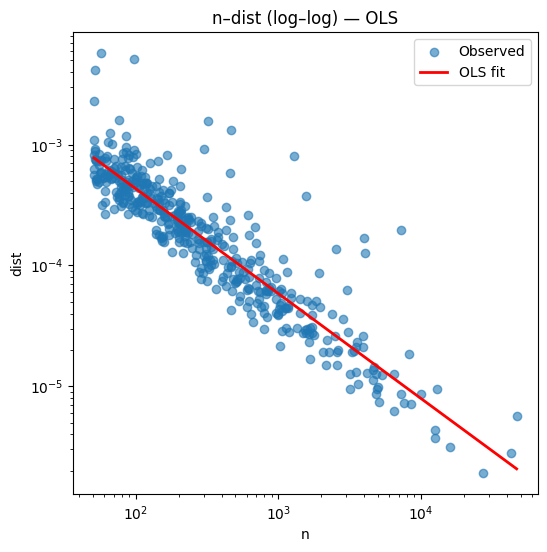

In [56]:
order = np.argsort(devi["n"])
plt.figure(figsize=(6, 6))

plt.scatter(
    devi["n"],
    devi["dist"],
    alpha=0.6,
    label="Observed"
    )

plt.plot(
    devi["n"].values[order],
    devi["dist_pred_ols"].values[order],
    color="red",
    linewidth=2,
    label="OLS fit"
    )

plt.xscale("log")
plt.yscale("log")
plt.xlabel("n")
plt.ylabel("dist")
plt.title("n–dist (log–log) — OLS")
plt.legend()
plt.show()

Plot of residuals

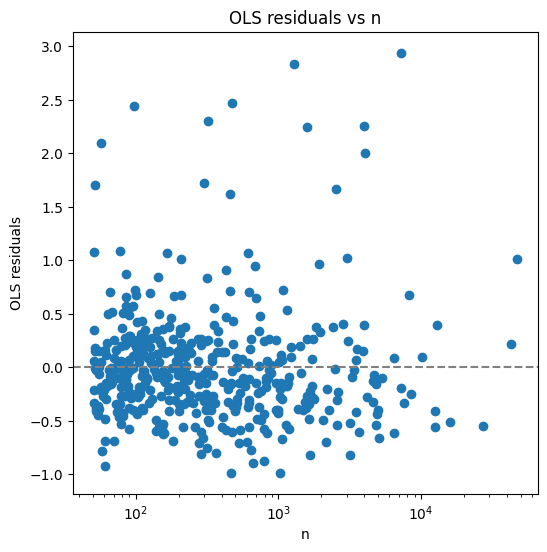

In [57]:
plt.figure(figsize=(6, 6))
plt.scatter(devi["n"], devi["resid_ols"])
plt.axhline(0, color="gray", linestyle="--")
plt.xscale("log")
plt.xlabel("n")
plt.ylabel("OLS residuals")
plt.title("OLS residuals vs n")
plt.show()



---



**Theil-Sen Estimator**

First, prepare data again for this method:

In [58]:
from sklearn.linear_model import TheilSenRegressor

X_1 = np.log(devi["n"].values).reshape(-1,1)
y_1 = np.log(devi["dist"].values)

Then, fitting of the Theil-Sen

In [59]:
ts = TheilSenRegressor(random_state=0)
ts.fit(X_1,y_1)

TheilSenRegressor(random_state=0)

Extraction of coefficients:

In [60]:
beta_0_ts = ts.intercept_
beta_1_ts = ts.coef_[0]

print("Slope ts:", beta_1_ts)
print("Beta ts intercept:", beta_0_ts)

Slope ts: -0.9054833028148936
Beta ts intercept: -3.6225102494832844


By these results, we can

* Beta 1 being -3.622 present an aggressive decay compared to a beta 1 equal to 1

Prediction and residuals explicitly

In [61]:
y_pred_ts = ts.predict(X_1)
resid_ts = y - y_pred_ts

Now, let's plot de distance with the Theil-Sen fit:

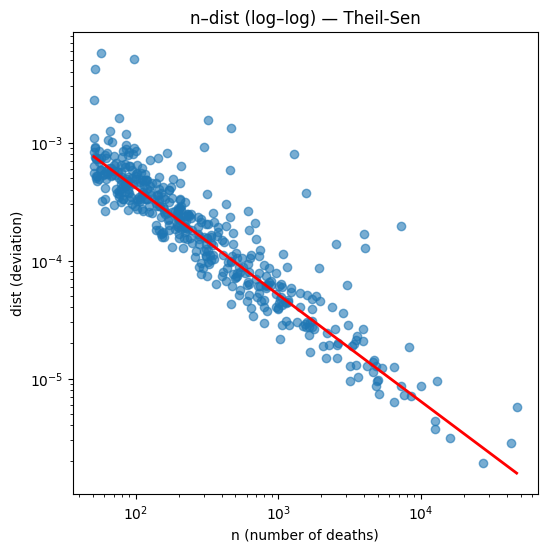

In [62]:
plt.figure(figsize=(6, 6))
plt.scatter(devi["n"],
            devi["dist"],
            alpha=0.6,
            label="Observed")

n_sorted = np.sort(devi["n"].values)
X_line = np.log(n_sorted).reshape(-1, 1)
y_line = np.exp(ts.predict(X_line))

plt.plot(n_sorted,
         y_line,
         color="red",
         linewidth=2,
         label="TS fit")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("n (number of deaths)")
plt.ylabel("dist (deviation)")
plt.title("n–dist (log–log) — Theil-Sen")
plt.show()

Now, the residual plot

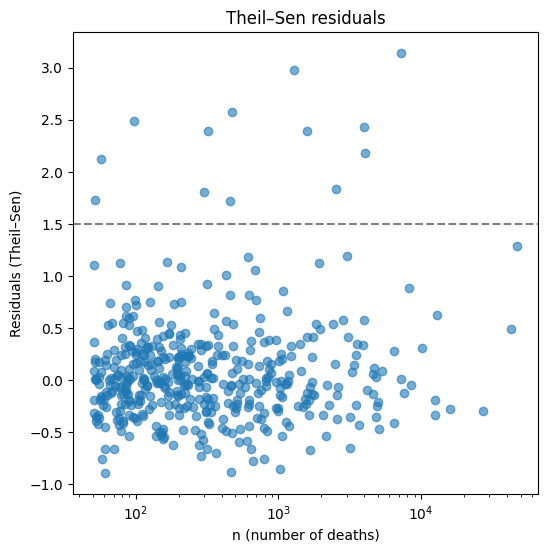

In [63]:
plt.figure(figsize=(6, 6))
plt.scatter(devi["n"], resid_ts, alpha=0.6)
plt.axhline(1.5, color="gray", linestyle="--")
plt.xscale("log")
plt.xlabel("n (number of deaths)")
plt.ylabel("Residuals (Theil–Sen)")
plt.title("Theil–Sen residuals")
plt.show()



---



**Huber Regressor**

Once again, the data preparation

In [64]:
from sklearn.linear_model import HuberRegressor

X_2 = np.log(devi["n"].values).reshape(-1,1)
y_2 = np.log(devi["dist"].values)

Now, let's fit the Huber Regressor for the log-log data.

In [65]:
huber = HuberRegressor()
huber.fit(X_2,y_2)

HuberRegressor()

Extraction of the coefficients beta 0 and 1, for intercept and slope.

In [66]:
beta_0_h = huber.intercept_
beta_1_h = huber.coef_[0]

print("Intercept ts:",beta_0_h)
print("Slope ts:",beta_1_h)

Intercept ts: -3.6288163545284924
Slope ts: -0.9015138893881545


Obtaining these results, means that:

* If the sample size increases by 1%, the deviation decreases by approxitemaly 0.9%

Last, predictions and residuals obtained from the data

In [67]:
y_pred_h = huber.predict(X_2)
resid_h = y - y_pred_h

y_huber_line = np.exp(huber.predict(X_line))

Now, let's plot the line obtained with the residuals from this method

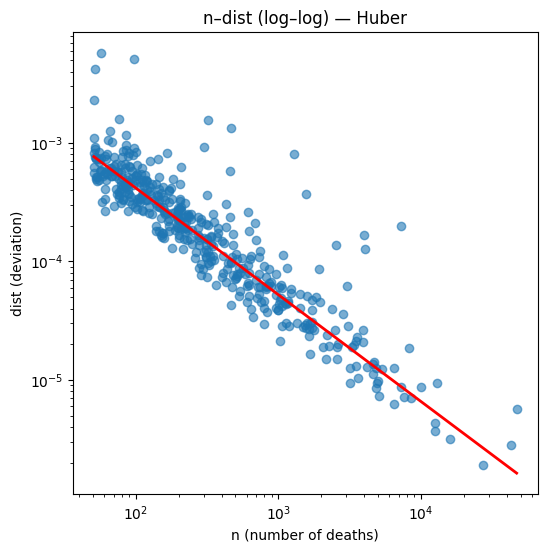

In [68]:
plt.figure(figsize=(6, 6))
plt.scatter(devi["n"],
            devi["dist"],
            alpha=0.6,
            label="Observed")

n_sorted = np.sort(devi["n"].values)
X_line = np.log(n_sorted).reshape(-1, 1)
y_line = np.exp(ts.predict(X_line))

plt.plot(n_sorted, y_huber_line, label="Huber", color="red", linewidth=2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("n (number of deaths)")
plt.ylabel("dist (deviation)")
plt.title("n–dist (log–log) — Huber")
plt.show()

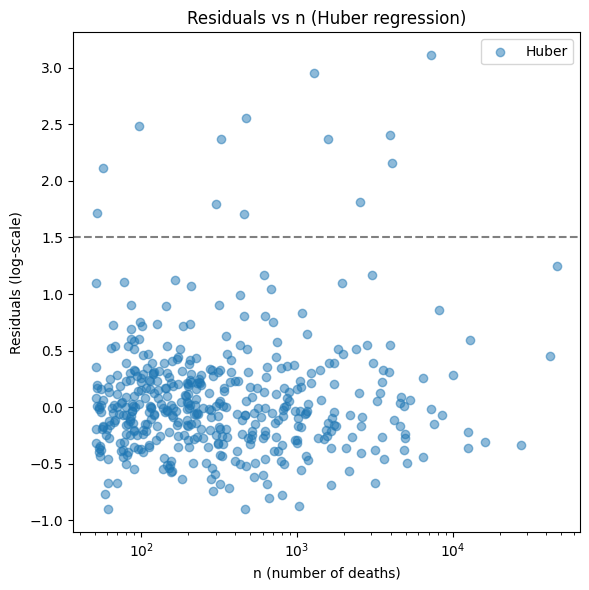

In [69]:
plt.figure(figsize=(6, 6))

plt.scatter(devi["n"], resid_h, alpha=0.5, label="Huber")
plt.axhline(1.5, color="gray", linestyle="--")
plt.xscale("log")
plt.xlabel("n (number of deaths)")
plt.ylabel("Residuals (log-scale)")
plt.title("Residuals vs n (Huber regression)")
plt.legend()
plt.tight_layout()
plt.show()



---



## Graph comparison

Let's note the lines and predictions from the models again:

In [70]:
y_ols_line = np.exp(ols.predict(X_line))

y_ts_line = np.exp(ts.predict(X_line))

y_huber_line = np.exp(huber.predict(X_line))

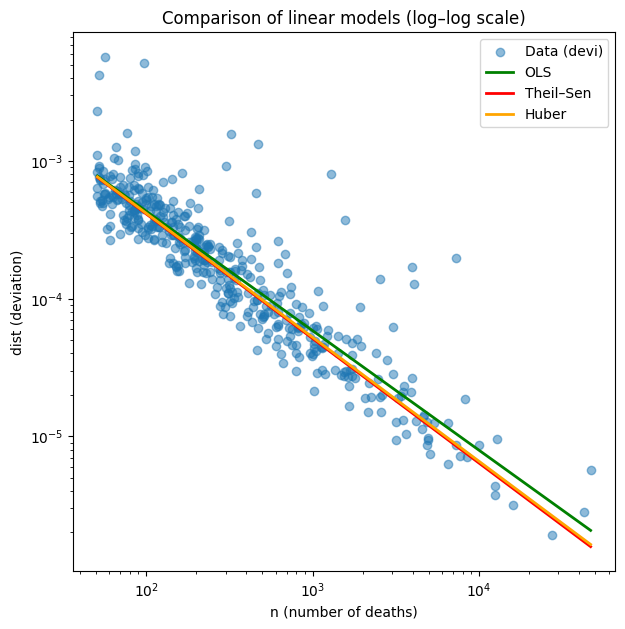

In [71]:
plt.figure(figsize=(7, 7))

plt.scatter(devi["n"], devi["dist"], alpha=0.5, label="Data (devi)")
plt.plot(n_sorted, y_ols_line, label="OLS", color="green", linewidth=2)
plt.plot(n_sorted, y_ts_line, label="Theil–Sen", color="red", linewidth=2)
plt.plot(n_sorted, y_huber_line, label="Huber", color="orange",linewidth=2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("n (number of deaths)")
plt.ylabel("dist (deviation)")
plt.title("Comparison of linear models (log–log scale)")
plt.legend()

plt.show()


Let's remember the residuals obtained from each method

In [72]:
y_pred_ols = ols.predict(X_log)
resid_ols = y_log - y_pred_ols

y_pred_ts = ts.predict(X_1)
resid_ts = y_1 - y_pred_ts

y_pred_h = huber.predict(X_1)
resid_h = y_2 - y_pred_h

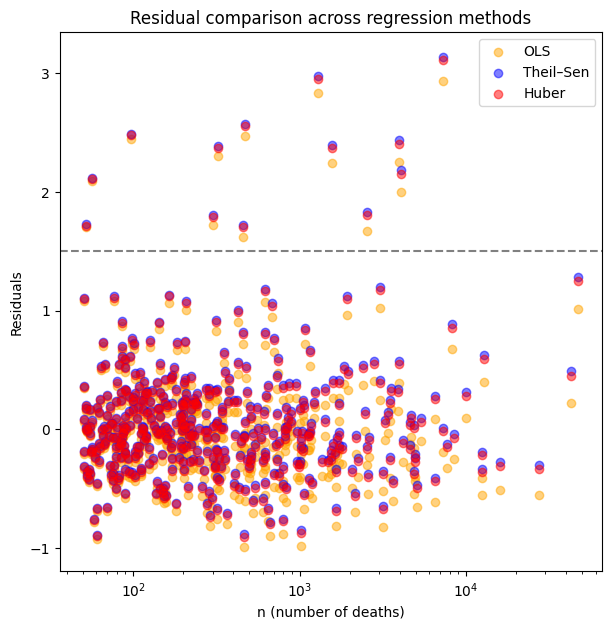

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))

plt.scatter(devi["n"], resid_ols, alpha=0.5, color="orange", label="OLS")
plt.scatter(devi["n"], resid_ts, alpha=0.5, color="blue", label="Theil–Sen")
plt.scatter(devi["n"], resid_h, alpha=0.5, color="red",label="Huber")
plt.axhline(1.5, color="gray", linestyle="--")
plt.xscale("log")
plt.xlabel("n (number of deaths)")
plt.ylabel("Residuals")
plt.title("Residual comparison across regression methods")
plt.legend()

plt.show()



---



## MAD comparison

For the comparison of results obtained of these 3 methods, we will be using the Median Absolute Deviation.

MAD will be able to evaluate our results, letting us know based on our data points, how far is the model's prediction from the observed value.

In [74]:
from scipy.stats import median_abs_deviation

mad_ols = median_abs_deviation(resid_ols)
mad_ts = median_abs_deviation(resid_ts)
mad_h = median_abs_deviation(resid_h)

results = pd.DataFrame({
    "Model": ["OLS", "Theil–Sen", "Huber"],
    "MAD (Median |residual|)": [mad_ols, mad_ts, mad_h]})

results

,Model,MAD (Median |residual|)
0,OLS,0.258631
1,Theil–Sen,0.243991
2,Huber,0.245828


Also, we can do a little comparison based on the model proposed on the case study (RLM), obtaining:

In [75]:
resid_rlm=devi["resid"]
mad_rlm = median_abs_deviation(resid_rlm)
print("MAD from first model of case study (RLM):",mad_rlm)

MAD from first model of case study (RLM): 0.24739061367268178


In [76]:
mad_results = {"OLS": 0.262647,"Theil–Sen": 0.243991,"Huber": 0.245828}

table = pd.DataFrame({
    "Model": mad_results.keys(),
    "Approx. typical error": [
        f"~{100 * (np.exp(mad) - 1):.1f}%"
        for mad in mad_results.values()]})

table

,Model,Approx. typical error
0,OLS,~30.0%
1,Theil–Sen,~27.6%
2,Huber,~27.9%


Based on these values, we can conclude:



*   OLS is the worst model of all 3 because sacrifices accuracy for the majority of causes of death, the data also presents some extreme values making a little distortion on the slope. MAD exposes this weakness clearly.
*   Both, Theil-Sen and Huber come very close in results.
*   Theil-Sen present better results as the most robust estimator, ignoring the magnitude of outliers. This one was the best method from all 3.



More information will be available on the report "*Tidy Data: Case Study*".